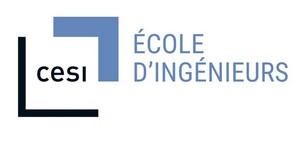

<h1 align='center'>Projet Leyenda - Livrable 2 - Traitement d'images</h1>
<h3 align='center'>Youssef AYARI, Matthieu DECLERCQ, Thomas PETAIN, Julien BARON, Jean-Baptiste CASTELLANI</h1>

## Sommaire

* [Introduction](#chapter1)
* [1. Contraintes](#chapter2)
* [2. Configuration de l'environnement](#chapter3)
    * [2.1 Import des librairies Python](#section_2_1)
    * [2.2 Utilisation du GPU](#section_2_2)
* [3. Préparation du dataset](#chapter4)
    * [3.1 Création d'un jeu d'entraînement et de test](#section_3_1)
    * [3.2 Bruitage du jeu de données](#section_3_2)
* [4. Création du Modèle](#chapter5)
    * [4.1 Encodeur Décodeur](#section_5_1)
    * [4.2 Implémentation du modèle](#section_5_2)
    * [4.3 Amélioration du modèle](#section_5_3)
* [5. Mesure de la performance](#chapter6)
* [6. Etude de cas](#chapiter7)
* [7. Conclusion](#chapiter8)

## Introduction <a class="anchor" id="chapter1"></a>

<div style="text-align: justify">Dans le cadre de ce projet, l'entreprise TouNum, spécialisée dans la numérisation de documents, souhaite étendre leur gamme de services pour inclure des outils de Machine Learning. En effet, leur clientèle possède une grande quantité de données à numériser au format papier. Dans le but de rester compétitif dans ce secteur d’activité, l’entreprise décide d’innover et de proposer un service de catégorisation qui serait plus que valorisable. Afin de mener à bien cette tâche, des spécialistes en Data Science du CESI ont été contactés.
<p><br>
    
<div style="text-align: justify">Dans la partie précedente nous avons classifié les photos et les autres images par le biais d'un CNN. Dans ce notebook nous abroderons le débruitage des photos afin de faciliter leur traitement par les algorithmes de machine Learning</div>

## 1. Contraintes <a class="anchor" id="chapter2"></a>

<div style="text-align: justify">Dans le but d'opérer une opération de débruitage nous devons réfléchir à une méthode qui nous permettra de réduire la dimension de notre image. En effet, lorsque nous traitons des images nous avons beaucoup de caractéristiques en entrée. Prenons une image 28 x 28 pixel, dans ce cas nous aurons 784 inputs dans notre réseau de neurones. Avec autant de dimension ce qui rend le traitement et l'analyse compliqué.</div><br>

<div style="text-align: justify">Nous connaissons des méthodes permettant de réduire les dimensions de notre image. Nous pouvons citer dans un premier temps l'ACP ( Analyse en Composantes Principale). Néanmoins cette solution ne nous satisfait pas car les relations entre les caractéristiques et les points de données dans un espace à haute dimension présentent une relation non linéaire.</div><br>

<div style="text-align: justify">Dans ce cas de figure nous pouvons alors nous tourner vers le TSNE. Néanmoins, cet algorithme bien que très efficace ne convainc pas du fait qu'il reste très gourmand en ressources. Par conséquent nous nous devons trouver un algorithme qui nous permet de garder une approche non linéaire tout en conservant des performances acceptables.</div><br>


## 2. Configuration de l'environnement <a class="anchor" id="chapter3"></a>

Tout comme dans le premier livrable nous nous devons de préparer notre environnement de travail pour mener à bien notre projet. Par conséquent nous reviendrons sur les mêmes points qui ont été aborder précédemment qui sont : l'import des librairies Python et l'utilisattion du GPU. 

### 2.1 Import des librairies Python <a class="anchor" id="section_3_1"></a>

Dans le cadre de ce premier livrable, nous avons décidé d’importer plusieurs librairies Python que nous allons présenter :
<ul>
    <li style="text-align: justify"><strong>TensorFlow</strong> : est un outil open source d'apprentissage automatique développé par Google. Il est l'un des outils les plus utilisés en IA dans le domaine de l'apprentissage machine. Celui-ci contient de nombreuses implémentations de blocs nécessaire à la construction de réseaux de neurones couramment utilisés tels que des couches, des fonctions d'activation, des optimiseurs et une multitude d'outils pour faciliter le travail avec des images ou des textes afin de simplifier le codage nécessaire à l'écriture de code de réseau de neurones profond. <strong>Keras</strong> est l’API haut niveau s’exécutant sur la plateforme d’apprentissage automatique Tensorflow. Elle permet de faciliter la création et l’entraînement des modèles de deep learning.</li><br>
</ul>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import numpy as np
import pathlib

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, Dropout
from tensorflow.keras.models import Model, Sequential
from random import randrange
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers

### 2.2 Utilisation du GPU <a class="anchor" id="section_2_1"></a>

<div style="text-align: justify">Dans l'optique d’avoir de meilleures performances tout au long de ce projet notamment durant l’entraînement du modèle, nous avons décidé de faire passer le traitement des données par le GPU. Pour ce faire, la ligne ci-dessous nous indique si le système détecte un GPU qui peut être utilisé. (Seules les cartes Nvdia avec Cuda installé sont reconnues par Tensorflow).<div>

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 3. Préparation du dataset <a class="anchor" id="chapter4"></a>

<div style="text-align: justify"> Nous avons vu comment dans le premier livrable comment préparer notre jeux de données pour les algorithme de deep learning. Néanmoins, nous devrons rajouter intentionellement du bruit sur nos images dans le but de pouvoir entrainer nos modèles dans les meilleures conditons.</div>

In [3]:
data_dir = r"D:/exia/A5 2021-2022/Option_DataScience/Data"
image_h = 256
image_w = 256
batch_s = 9

### 3.1 Création des jeux d'entrainement et de test <a class="anchor" id="section_4_1"></a>

<div style="text-align: justify">Pour préparer le jeu de données, nous le séparons en deux sous-ensembles homogènes afin d'éviter la sous-représentation de classe. Le premier sous-ensemble dit d'entraînement permettra au modèle d'ajuster ses poids et par conséquent améliorer sa classification. Le second nous permet d'évaluer la classification du modèle. C'est sur ce jeu de données qu'on se base pour le calcul de la précision du modèle.<div>   

In [4]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="training",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  color_mode="rgb"
)

# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="validation",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  color_mode="rgb"
)

Found 13747 files belonging to 1 classes.
Using 10998 files for training.
Found 13747 files belonging to 1 classes.
Using 2749 files for validation.


### 3.2 Bruitage du jeu de données <a class="anchor" id="section_4_2"></a>

<div style="text-align: justify">Notre dataset ne contenant pas d'image bruitée, nous devons par conséquent ajouter un bruit gaussien aléatoire sur chaque image. Pour ce faire nous générons aléatoirement un entier que nous multiplions par un facteur et additionnons à notre image.</div>

In [5]:
#process image 
def preprocess(data):
    data = np.array(data, dtype=np.float32) #conversion de l'image en narray de nombre de flotan
    data = data.astype('float32') / 255.0 #Normalisation des données de narray
    data = np.reshape(data, (len(data), image_h, image_w, 3))# redimensionnement de l'array
    return data

#Bruitage de l'image
def noise_it(data, noise_factor = 0.2):
    data_noisy = data + noise_factor * tf.random.normal(shape = data.shape)
    return np.clip(data_noisy, 0., 1.)#Normalization des données après le bruitage
    
#Sépare les features des labels 
def split_dataset(data):
    for photo_batch, label_batch in data:
        photo = photo_batch
        break
    return photo

x_train = split_dataset(train_set)
x_test = split_dataset(test_set)

x_train = preprocess(x_train)
x_test = preprocess(x_test)

x_train_noisy = noise_it(x_train) 
x_test_noisy = noise_it(x_test)

Nous pouvons voir ci-dessous que les images issus de notre dataset on bien été bruité.

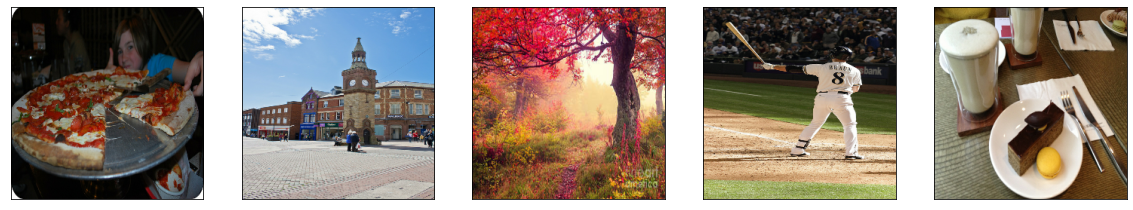

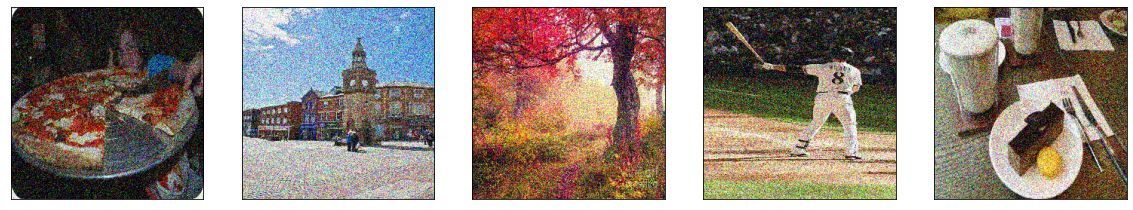

In [6]:
#Affichage d'image
def display_image(X, n):
    plt.figure(figsize=(20, 20))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(X[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

display_image(x_train,5)
display_image(x_train_noisy, 5)

## 4 Création du modèle <a class="anchor" id="chapter5"></a>

<div style="text-align: justify">Nous avons maintenaint un dataset nétoyé et prêt à être exploité pour l'entrainement des modèles. Par conséquent cette partie s'axe sur le dévloppement et l'évaluation du modèle.</div>

### 4.1 Encodeur Décodeur <a class="anchor" id = "section_5_1">

<div style="text-align: justify">Cette architecture fonctionne sur la base de 2 concepts qui nous permettrons de prendre en entré une image bruité :</div><br>

<div style="text-align: justify">-<strong>l'Encodeur</strong>: L'objectif de cette étape est de sous-échantillonner l’image en entrée. Pour ce faire nous allons utiliser des opérations de convolution comme vu précédemment dans le livrable 1. Ce qui aura pour conséquence de réduire la taille de l’image d’entrée. A la suite des opérations de convolution nous obtiendrons une représentation vectorielle de notre image appelée espace latent.</div><br>

<div style="text-align: justify">-<strong>Décodeur</strong>: La seconde partie appelée décodeur prend en entrée l’espace latent généré par l’encodeur. Son objectif sera de reconstruire l’image en supprimant le bruit . Pour ce faire, nous utilisons des couches de convolutions transposées. Ces couches, vont rééchantillonner l’image à partir des caractéristiques de l’espace latent. Comme le montre le schéma ci-dessous :</div><br>

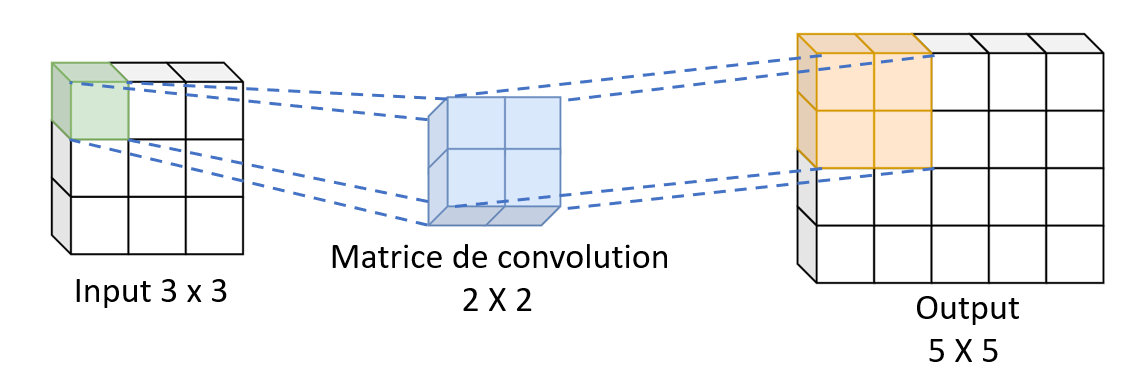
<br>

<div style="text-align: justify">Cette architecture répond parfaitement à la problématique posée précédemment dans le notebook. En effet, nous avons pu diminuer la dimension de manière non-linéaire tout en gardant des performances qui sont très acceptables.</div>


### 4.2 Implémentation du modèle <a class="anchor" id = "section_5_2">

<div style="text-align: justify">Dans cette partie nous allons implémenter le modèle d’auto-encodeur décrit précédemment. Nous définissons au préalable les variables utiles au modèle tel que le nombre d'époque ou la taille du batch.</div>

In [ ]:
nb_epochs = 1000
batch_size = 18

#### 4.2.1 Définition du modèle <a class="anchor" id = "section_5_2_1">

In [ ]:
inputs = Input(shape=(image_w, image_w, 3))

#Encoder
x = Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)


# Decoder
x = Conv2D(256, (3, 3),  activation="relu", padding="same")(x)
x = Conv2D(128, (3, 3),  activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(inputs, x)
model_opt = tf.keras.optimizers.Adam()
autoencoder.compile(optimizer=model_opt, loss="binary_crossentropy")
autoencoder.summary()

#### 4.2.3 Sauvegarde du meilleure modèle  <a class="anchor" id="section_5_2_3"></a>

In [ ]:
callback_bestmodel = tf.keras.callbacks.ModelCheckpoint(filepath='./models/new_model.h5', verbose=0, save_best_only=True)
callbacks_list = [callback_bestmodel]

#### 4.2.4 Entrainement du modèle  <a class="anchor" id="section_5_2_4"></a>

In [ ]:
history = autoencoder.fit(
    x=x_train_noisy,
    y=x_train,
    epochs=nb_epochs,
    batch_size=batch_size,
    validation_data=(x_test_noisy, x_test),
    callbacks = callbacks_list
)

#### 4.2.5 Visualisation des résultats <a class="anchor" id="section_5_2_4"></a>

In [8]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [ ]:
model_dir = r"C://Users//jujub//Option_DataScience//repo2//models//best_model.h5"
model = keras.models.load_model(model_dir)
predictions = model.predict(x_test_noisy)
display_image(x_test, 5)
display_image(x_test_noisy, 5)
display_image(predictions, 5)

### 4.3 Amélioration du modèle <a class="anchor" id="section_5_3"></a>

#### 4.3.1 Définition des layers <a class="anchor" id="section_5_3_1"></a>

In [9]:
from keras.initializers import orthogonal
import keras.models as models
import keras.layers as layers
def Conv2DLayer(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = Conv2D(filters, kernel_size=kernel, strides=strides, padding=padding,
                      kernel_initializer=kernel_init, name=prefix+'conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

def Transpose_Conv2D(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = Conv2DTranspose(filters, kernel_size=kernel, strides=strides, padding=padding,
                               kernel_initializer=kernel_init, name=prefix+'de-conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

#### 4.3.2 Définition du modèle  <a class="anchor" id="section_5_3_2"></a>

In [8]:
def AutoEncdoer(input_shape):
    inputs = Input(shape=input_shape)
    
    # 256 x 256
    conv1 = Conv2DLayer(inputs, 64, 3, strides=1, padding='same', block_id=1)
    conv2 = Conv2DLayer(conv1, 64, 3, strides=2, padding='same', block_id=2)
    
    # 128 x 128
    conv3 = Conv2DLayer(conv2, 128, 5, strides=2, padding='same', block_id=3)
    
    # 64 x 64
    conv4 = Conv2DLayer(conv3, 128, 3, strides=1, padding='same', block_id=4)
    conv5 = Conv2DLayer(conv4, 256, 5, strides=2, padding='same', block_id=5)
    
    # 32 x 32
    conv6 = Conv2DLayer(conv5, 512, 3, strides=2, padding='same', block_id=6)
    
    # 16 x 16
    deconv1 = Transpose_Conv2D(conv6, 512, 3, strides=2, padding='same', block_id=7)
    
    # 32 x 32
    skip1 = layers.concatenate([deconv1, conv5], name='skip1')
    conv7 = Conv2DLayer(skip1, 256, 3, strides=1, padding='same', block_id=8)
    deconv2 = Transpose_Conv2D(conv7, 128, 3, strides=2, padding='same', block_id=9)
    
    # 64 x 64
    skip2 = layers.concatenate([deconv2, conv3], name='skip2')
    conv8 = Conv2DLayer(skip2, 128, 5, strides=1, padding='same', block_id=10)
    deconv3 = Transpose_Conv2D(conv8, 64, 3, strides=2, padding='same', block_id=11)
    
    # 128 x 128
    skip3 = layers.concatenate([deconv3, conv2], name='skip3')
    conv9 = Conv2DLayer(skip3, 64, 5, strides=1, padding='same', block_id=12)
    deconv4 = Transpose_Conv2D(conv9, 64, 3, strides=2, padding='same', block_id=13)
    
    # 256 x 256
    skip3 = layers.concatenate([deconv4, conv1])
    conv10 = layers.Conv2D(3, 3, strides=1, padding='same', activation='sigmoid',
                       kernel_initializer=orthogonal(), name='final_conv')(skip3)

    
    return models.Model(inputs=inputs, outputs=conv10)

In [ ]:
model = AutoEncdoer((image_h, image_w, 3))
model_opt = tf.keras.optimizers.Adam(lr=0.002)
model.compile(optimizer=model_opt, loss='binary_crossentropy', metrics=['accuracy'])

#### 4.3.3 Sauvegarde du meilleure modèle  <a class="anchor" id="section_5_3_3"></a>

In [11]:
callback_bestmodel_improved = tf.keras.callbacks.ModelCheckpoint(filepath='./models_improved/new_model.h5', verbose=0, save_best_only=True)
callbacks_list_improved = [callback_bestmodel_improved]

#### 4.3.3 Entrainement du modèle <a class="anchor" id="section_5_3_3"></a>

In [ ]:
history = model.fit(
    x=x_train_noisy,
    y=x_train,
    epochs=nb_epochs,
    batch_size=18,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks = callbacks_list
)

#### 4.3.4 Visualisation des résultats <a class="anchor" id="section_5_3_4"></a>

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [ ]:
model_dir = r"C://Users//jujub//Option_DataScience//repo2//models//new_model.h5"
model = tf.keras.models.load_model(model_dir)
predictions = model.predict(x_test)
display_image(x_test, 5)
display_image(x_test_noisy, 5)
display_image(predictions, 5)

## 5 Mesure de la performance du modèle <a class="anchor" id="chapter6"></a>

In [13]:
# inputs = Input(shape=(image_w, image_w, 3))

# x = Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
# x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
# x = MaxPooling2D((2, 2), padding="same")(x)
# x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
# x = MaxPooling2D((2, 2), padding="same")(x)
# x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
# x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
# x = MaxPooling2D((2, 2), padding="same")(x)
# x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
# x = MaxPooling2D((2, 2), padding="same")(x)

# # Decoder
# x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(256, (3, 3),  activation="relu", padding="same")(x)
# x = Conv2D(128, (3, 3),  activation="relu", padding="same")(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
# x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# # Autoencoder
# autoencoder = Model(inputs, x)
# model_opt = tf.keras.optimizers.Adam(lr=0.002)
# autoencoder.compile(optimizer=model_opt, loss="binary_crossentropy", metrics=['accuracy'])
# autoencoder.summary()

Epoch 1/1000
1/1 [==============================] - 6s 6s/step - loss: 0.1442 - accuracy: 0.3171 - val_loss: 0.0967 - val_accuracy: 0.2437
Epoch 2/1000
1/1 [==============================] - 0s 236ms/step - loss: 0.0500 - accuracy: 0.3773 - val_loss: 0.2365 - val_accuracy: 0.2862
Epoch 3/1000
1/1 [==============================] - 0s 237ms/step - loss: 0.0291 - accuracy: 0.4323 - val_loss: 0.4208 - val_accuracy: 0.2711
Epoch 4/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0285 - accuracy: 0.4900 - val_loss: 0.4376 - val_accuracy: 0.4371
Epoch 5/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0269 - accuracy: 0.5386 - val_loss: 0.4394 - val_accuracy: 0.4874
Epoch 6/1000
1/1 [==============================] - 0s 237ms/step - loss: 0.0255 - accuracy: 0.5673 - val_loss: 0.4395 - val_accuracy: 0.4923
Epoch 7/1000
1/1 [==============================] - 0s 236ms/step - loss: 0.0225 - accuracy: 0.5854 - val_loss: 0.4391 - val_accuracy: 0.4882
Epoch 8/1

1/1 [==============================] - 0s 237ms/step - loss: 0.0061 - accuracy: 0.6662 - val_loss: 0.3748 - val_accuracy: 0.3340
Epoch 116/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0060 - accuracy: 0.6668 - val_loss: 0.3726 - val_accuracy: 0.3350
Epoch 117/1000
1/1 [==============================] - 0s 236ms/step - loss: 0.0060 - accuracy: 0.6686 - val_loss: 0.3751 - val_accuracy: 0.3341
Epoch 118/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0060 - accuracy: 0.6711 - val_loss: 0.3774 - val_accuracy: 0.3331
Epoch 119/1000
1/1 [==============================] - 0s 236ms/step - loss: 0.0060 - accuracy: 0.6708 - val_loss: 0.3774 - val_accuracy: 0.3329
Epoch 120/1000
1/1 [==============================] - 0s 237ms/step - loss: 0.0060 - accuracy: 0.6711 - val_loss: 0.3772 - val_accuracy: 0.3330
Epoch 121/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0059 - accuracy: 0.6712 - val_loss: 0.3760 - val_accuracy: 0.3336
Epoch 1

Epoch 172/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0051 - accuracy: 0.7012 - val_loss: 0.0498 - val_accuracy: 0.5140
Epoch 173/1000
1/1 [==============================] - 0s 241ms/step - loss: 0.0051 - accuracy: 0.7040 - val_loss: 0.0497 - val_accuracy: 0.5143
Epoch 174/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0051 - accuracy: 0.7046 - val_loss: 0.0494 - val_accuracy: 0.5145
Epoch 175/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0051 - accuracy: 0.7055 - val_loss: 0.0493 - val_accuracy: 0.5148
Epoch 176/1000
1/1 [==============================] - 0s 237ms/step - loss: 0.0051 - accuracy: 0.6991 - val_loss: 0.0494 - val_accuracy: 0.5156
Epoch 177/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0051 - accuracy: 0.7024 - val_loss: 0.0494 - val_accuracy: 0.5160
Epoch 178/1000
1/1 [==============================] - 0s 242ms/step - loss: 0.0051 - accuracy: 0.7011 - val_loss: 0.0493 - val_accuracy:

Epoch 229/1000
1/1 [==============================] - 0s 236ms/step - loss: 0.0047 - accuracy: 0.7238 - val_loss: 0.0434 - val_accuracy: 0.5182
Epoch 230/1000
1/1 [==============================] - 0s 236ms/step - loss: 0.0046 - accuracy: 0.7254 - val_loss: 0.0434 - val_accuracy: 0.5192
Epoch 231/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0046 - accuracy: 0.7222 - val_loss: 0.0431 - val_accuracy: 0.5199
Epoch 232/1000
1/1 [==============================] - 0s 237ms/step - loss: 0.0046 - accuracy: 0.7273 - val_loss: 0.0430 - val_accuracy: 0.5201
Epoch 233/1000
1/1 [==============================] - 0s 237ms/step - loss: 0.0046 - accuracy: 0.7270 - val_loss: 0.0428 - val_accuracy: 0.5201
Epoch 234/1000
1/1 [==============================] - 0s 237ms/step - loss: 0.0046 - accuracy: 0.7242 - val_loss: 0.0424 - val_accuracy: 0.5198
Epoch 235/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0046 - accuracy: 0.7319 - val_loss: 0.0427 - val_accuracy:

Epoch 286/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0044 - accuracy: 0.7466 - val_loss: 0.0347 - val_accuracy: 0.5395
Epoch 287/1000
1/1 [==============================] - 0s 237ms/step - loss: 0.0044 - accuracy: 0.7366 - val_loss: 0.0339 - val_accuracy: 0.5392
Epoch 288/1000
1/1 [==============================] - 0s 240ms/step - loss: 0.0043 - accuracy: 0.7402 - val_loss: 0.0335 - val_accuracy: 0.5388
Epoch 289/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0043 - accuracy: 0.7477 - val_loss: 0.0338 - val_accuracy: 0.5410
Epoch 290/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0043 - accuracy: 0.7422 - val_loss: 0.0339 - val_accuracy: 0.5419
Epoch 291/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0043 - accuracy: 0.7368 - val_loss: 0.0334 - val_accuracy: 0.5404
Epoch 292/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0043 - accuracy: 0.7455 - val_loss: 0.0329 - val_accuracy:

Epoch 343/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0042 - accuracy: 0.7517 - val_loss: 0.0240 - val_accuracy: 0.5905
Epoch 344/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0042 - accuracy: 0.7530 - val_loss: 0.0239 - val_accuracy: 0.5959
Epoch 345/1000
1/1 [==============================] - 0s 240ms/step - loss: 0.0042 - accuracy: 0.7542 - val_loss: 0.0235 - val_accuracy: 0.6005
Epoch 346/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0042 - accuracy: 0.7471 - val_loss: 0.0238 - val_accuracy: 0.6039
Epoch 347/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0042 - accuracy: 0.7483 - val_loss: 0.0239 - val_accuracy: 0.5979
Epoch 348/1000
1/1 [==============================] - 0s 241ms/step - loss: 0.0042 - accuracy: 0.7587 - val_loss: 0.0233 - val_accuracy: 0.5991
Epoch 349/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0042 - accuracy: 0.7585 - val_loss: 0.0229 - val_accuracy:

Epoch 400/1000
1/1 [==============================] - 0s 237ms/step - loss: 0.0040 - accuracy: 0.7672 - val_loss: 0.0155 - val_accuracy: 0.6413
Epoch 401/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0040 - accuracy: 0.7663 - val_loss: 0.0162 - val_accuracy: 0.6539
Epoch 402/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0040 - accuracy: 0.7629 - val_loss: 0.0161 - val_accuracy: 0.6471
Epoch 403/1000
1/1 [==============================] - 0s 241ms/step - loss: 0.0040 - accuracy: 0.7634 - val_loss: 0.0155 - val_accuracy: 0.6469
Epoch 404/1000
1/1 [==============================] - 0s 240ms/step - loss: 0.0040 - accuracy: 0.7614 - val_loss: 0.0157 - val_accuracy: 0.6503
Epoch 405/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0040 - accuracy: 0.7644 - val_loss: 0.0158 - val_accuracy: 0.6503
Epoch 406/1000
1/1 [==============================] - 0s 240ms/step - loss: 0.0040 - accuracy: 0.7664 - val_loss: 0.0152 - val_accuracy:

Epoch 457/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0038 - accuracy: 0.7691 - val_loss: 0.0108 - val_accuracy: 0.6993
Epoch 458/1000
1/1 [==============================] - 0s 240ms/step - loss: 0.0038 - accuracy: 0.7692 - val_loss: 0.0108 - val_accuracy: 0.7061
Epoch 459/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0038 - accuracy: 0.7708 - val_loss: 0.0104 - val_accuracy: 0.7001
Epoch 460/1000
1/1 [==============================] - 0s 241ms/step - loss: 0.0038 - accuracy: 0.7730 - val_loss: 0.0104 - val_accuracy: 0.6949
Epoch 461/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0038 - accuracy: 0.7732 - val_loss: 0.0104 - val_accuracy: 0.7028
Epoch 462/1000
1/1 [==============================] - 0s 242ms/step - loss: 0.0038 - accuracy: 0.7761 - val_loss: 0.0103 - val_accuracy: 0.7001
Epoch 463/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0038 - accuracy: 0.7768 - val_loss: 0.0101 - val_accuracy:

Epoch 514/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0037 - accuracy: 0.7751 - val_loss: 0.0072 - val_accuracy: 0.7350
Epoch 515/1000
1/1 [==============================] - 0s 237ms/step - loss: 0.0037 - accuracy: 0.7791 - val_loss: 0.0085 - val_accuracy: 0.6082
Epoch 516/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0050 - accuracy: 0.6955 - val_loss: 0.0945 - val_accuracy: 0.5282
Epoch 517/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0053 - accuracy: 0.7071 - val_loss: 0.2465 - val_accuracy: 0.4782
Epoch 518/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0051 - accuracy: 0.7199 - val_loss: 0.2651 - val_accuracy: 0.3955
Epoch 519/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0048 - accuracy: 0.7248 - val_loss: 0.2258 - val_accuracy: 0.3113
Epoch 520/1000
1/1 [==============================] - 0s 240ms/step - loss: 0.0049 - accuracy: 0.7085 - val_loss: 0.2101 - val_accuracy:

Epoch 571/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0039 - accuracy: 0.7485 - val_loss: 0.1040 - val_accuracy: 0.5998
Epoch 572/1000
1/1 [==============================] - 0s 237ms/step - loss: 0.0039 - accuracy: 0.7503 - val_loss: 0.1004 - val_accuracy: 0.6062
Epoch 573/1000
1/1 [==============================] - 0s 240ms/step - loss: 0.0039 - accuracy: 0.7517 - val_loss: 0.0972 - val_accuracy: 0.6125
Epoch 574/1000
1/1 [==============================] - 0s 237ms/step - loss: 0.0039 - accuracy: 0.7516 - val_loss: 0.0925 - val_accuracy: 0.6178
Epoch 575/1000
1/1 [==============================] - 0s 237ms/step - loss: 0.0039 - accuracy: 0.7513 - val_loss: 0.0855 - val_accuracy: 0.6250
Epoch 576/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0039 - accuracy: 0.7516 - val_loss: 0.0779 - val_accuracy: 0.6330
Epoch 577/1000
1/1 [==============================] - 0s 240ms/step - loss: 0.0039 - accuracy: 0.7518 - val_loss: 0.0713 - val_accuracy:

Epoch 628/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0037 - accuracy: 0.7663 - val_loss: 0.0051 - val_accuracy: 0.7304
Epoch 629/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0037 - accuracy: 0.7653 - val_loss: 0.0053 - val_accuracy: 0.7311
Epoch 630/1000
1/1 [==============================] - 0s 237ms/step - loss: 0.0037 - accuracy: 0.7675 - val_loss: 0.0055 - val_accuracy: 0.7328
Epoch 631/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0037 - accuracy: 0.7653 - val_loss: 0.0052 - val_accuracy: 0.7324
Epoch 632/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0037 - accuracy: 0.7644 - val_loss: 0.0052 - val_accuracy: 0.7274
Epoch 633/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0037 - accuracy: 0.7635 - val_loss: 0.0053 - val_accuracy: 0.7247
Epoch 634/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0037 - accuracy: 0.7637 - val_loss: 0.0051 - val_accuracy:

Epoch 685/1000
1/1 [==============================] - 0s 240ms/step - loss: 0.0036 - accuracy: 0.7746 - val_loss: 0.0046 - val_accuracy: 0.7315
Epoch 686/1000
1/1 [==============================] - 0s 240ms/step - loss: 0.0036 - accuracy: 0.7691 - val_loss: 0.0045 - val_accuracy: 0.7351
Epoch 687/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0036 - accuracy: 0.7659 - val_loss: 0.0045 - val_accuracy: 0.7370
Epoch 688/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0036 - accuracy: 0.7715 - val_loss: 0.0045 - val_accuracy: 0.7378
Epoch 689/1000
1/1 [==============================] - 0s 240ms/step - loss: 0.0036 - accuracy: 0.7726 - val_loss: 0.0045 - val_accuracy: 0.7374
Epoch 690/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0036 - accuracy: 0.7730 - val_loss: 0.0045 - val_accuracy: 0.7340
Epoch 691/1000
1/1 [==============================] - 0s 241ms/step - loss: 0.0036 - accuracy: 0.7681 - val_loss: 0.0045 - val_accuracy:

Epoch 742/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0035 - accuracy: 0.7717 - val_loss: 0.0041 - val_accuracy: 0.7501
Epoch 743/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0035 - accuracy: 0.7701 - val_loss: 0.0039 - val_accuracy: 0.7679
Epoch 744/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0036 - accuracy: 0.7777 - val_loss: 0.0039 - val_accuracy: 0.7655
Epoch 745/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0036 - accuracy: 0.7776 - val_loss: 0.0038 - val_accuracy: 0.7570
Epoch 746/1000
1/1 [==============================] - 0s 235ms/step - loss: 0.0036 - accuracy: 0.7721 - val_loss: 0.0039 - val_accuracy: 0.7681
Epoch 747/1000
1/1 [==============================] - 0s 240ms/step - loss: 0.0036 - accuracy: 0.7698 - val_loss: 0.0040 - val_accuracy: 0.7681
Epoch 748/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0036 - accuracy: 0.7727 - val_loss: 0.0040 - val_accuracy:

Epoch 799/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0035 - accuracy: 0.7799 - val_loss: 0.0039 - val_accuracy: 0.7502
Epoch 800/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0035 - accuracy: 0.7792 - val_loss: 0.0039 - val_accuracy: 0.7479
Epoch 801/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0035 - accuracy: 0.7776 - val_loss: 0.0039 - val_accuracy: 0.7520
Epoch 802/1000
1/1 [==============================] - 0s 240ms/step - loss: 0.0035 - accuracy: 0.7802 - val_loss: 0.0039 - val_accuracy: 0.7563
Epoch 803/1000
1/1 [==============================] - 0s 240ms/step - loss: 0.0035 - accuracy: 0.7813 - val_loss: 0.0040 - val_accuracy: 0.7535
Epoch 804/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0035 - accuracy: 0.7764 - val_loss: 0.0039 - val_accuracy: 0.7540
Epoch 805/1000
1/1 [==============================] - 0s 237ms/step - loss: 0.0035 - accuracy: 0.7784 - val_loss: 0.0039 - val_accuracy:

Epoch 856/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0034 - accuracy: 0.7795 - val_loss: 0.0037 - val_accuracy: 0.7614
Epoch 857/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0034 - accuracy: 0.7800 - val_loss: 0.0037 - val_accuracy: 0.7578
Epoch 858/1000
1/1 [==============================] - 0s 237ms/step - loss: 0.0034 - accuracy: 0.7838 - val_loss: 0.0037 - val_accuracy: 0.7560
Epoch 859/1000
1/1 [==============================] - 0s 237ms/step - loss: 0.0034 - accuracy: 0.7830 - val_loss: 0.0037 - val_accuracy: 0.7682
Epoch 860/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0034 - accuracy: 0.7815 - val_loss: 0.0037 - val_accuracy: 0.7650
Epoch 861/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0034 - accuracy: 0.7827 - val_loss: 0.0037 - val_accuracy: 0.7575
Epoch 862/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0034 - accuracy: 0.7846 - val_loss: 0.0037 - val_accuracy:

Epoch 913/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0034 - accuracy: 0.7885 - val_loss: 0.0036 - val_accuracy: 0.7695
Epoch 914/1000
1/1 [==============================] - 0s 240ms/step - loss: 0.0034 - accuracy: 0.7823 - val_loss: 0.0036 - val_accuracy: 0.7632
Epoch 915/1000
1/1 [==============================] - 0s 236ms/step - loss: 0.0034 - accuracy: 0.7835 - val_loss: 0.0036 - val_accuracy: 0.7672
Epoch 916/1000
1/1 [==============================] - 0s 241ms/step - loss: 0.0034 - accuracy: 0.7860 - val_loss: 0.0036 - val_accuracy: 0.7678
Epoch 917/1000
1/1 [==============================] - 0s 235ms/step - loss: 0.0034 - accuracy: 0.7900 - val_loss: 0.0036 - val_accuracy: 0.7669
Epoch 918/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0034 - accuracy: 0.7871 - val_loss: 0.0035 - val_accuracy: 0.7692
Epoch 919/1000
1/1 [==============================] - 0s 241ms/step - loss: 0.0034 - accuracy: 0.7868 - val_loss: 0.0035 - val_accuracy:

Epoch 970/1000
1/1 [==============================] - 0s 241ms/step - loss: 0.0033 - accuracy: 0.7850 - val_loss: 0.0035 - val_accuracy: 0.7655
Epoch 971/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.0033 - accuracy: 0.7872 - val_loss: 0.0036 - val_accuracy: 0.7614
Epoch 972/1000
1/1 [==============================] - 0s 241ms/step - loss: 0.0033 - accuracy: 0.7891 - val_loss: 0.0037 - val_accuracy: 0.7714
Epoch 973/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0033 - accuracy: 0.7905 - val_loss: 0.0036 - val_accuracy: 0.7749
Epoch 974/1000
1/1 [==============================] - 0s 240ms/step - loss: 0.0033 - accuracy: 0.7858 - val_loss: 0.0036 - val_accuracy: 0.7651
Epoch 975/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.0033 - accuracy: 0.7848 - val_loss: 0.0036 - val_accuracy: 0.7674
Epoch 976/1000
1/1 [==============================] - 0s 240ms/step - loss: 0.0033 - accuracy: 0.7887 - val_loss: 0.0036 - val_accuracy:

In [15]:
# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_h, image_h, 3)))
# model.add(MaxPooling2D((2, 2), padding='same'))
# model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D((2, 2), padding='same'))
# model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
 

# model.add(MaxPooling2D((2, 2), padding='same'))
     
# model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
# model.add(UpSampling2D((2, 2)))
# model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
# model.add(UpSampling2D((2, 2)))
# model.add(Conv2D(28, (3, 3), activation='relu', padding='same'))
# model.add(UpSampling2D((2, 2)))
# model.add(Conv2D(3, (3, 3), activation='relu', padding='same'))

In [16]:
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [17]:
# model.fit(x_train_noisy, x_train, epochs=10, batch_size=8, shuffle=True, verbose = 1)

In [18]:
# input_img = Input(shape=(image_w, image_h, 3))
# conv1_1 = Conv2D(32, (3,3), activation="relu", padding="same")(input_img)
# pool1_1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
# conv1_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1_1)
# pool1_2 = MaxPooling2D((2, 2), padding='same')(conv1_2)
# conv1_3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1_2)
# pool1_3 = MaxPooling2D((2, 2), padding='same')(conv1_3)

# conv2_1 = Conv2D(8, (3,3), activation="relu", padding="same")(pool1_3)
# pool2_1 = UpSampling2D()(conv2_1)
# conv2_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2_1)
# pool2_2 = UpSampling2D()(conv2_2)
# conv2_3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2_2)
# pool2_3 = UpSampling2D()(conv2_3)
# conv2_3 = Conv2D(3, (3, 3), activation='relu', padding='same')(pool2_3)

In [19]:
# autoencoder = Model(input_img, conv2_3)
# autoencoder.compile(optimizer=tf.keras.optimizers.Adadelta(), #"Adadelta" ne marche pas,
#                     loss="binary_crossentropy") 
# autoencoder.summary()

In [20]:
# ## Train the model
# history = autoencoder.fit(x_train_noisy, x_train,
#                 epochs=nb_epochs,
#                 batch_size= batch_size,
#                 shuffle= False,
#                 validation_data=(x_test_noisy, x_test)
#                 )

In [21]:
# # Visualisation des pertes d'apprentissage (Train) et de validation (Test)
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()

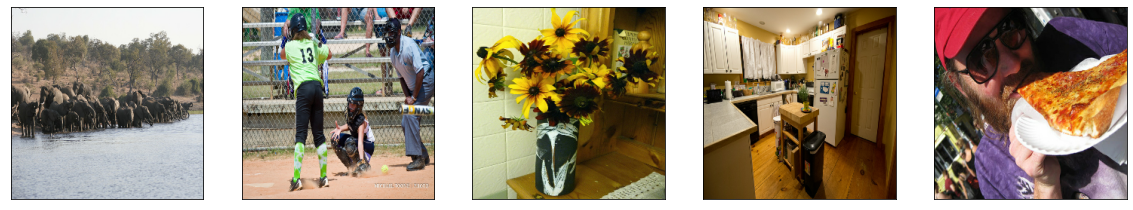

In [22]:
display_image(x_train,5)

In [23]:
# encoder_inputs = Input(shape = (image_h, image_w, 3))

# conv1_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder_inputs)
# pool1 = MaxPooling2D(padding='same')(conv1_1)
# conv1_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
# pool2 = MaxPooling2D(padding='same')(conv1_2)
# conv1_3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
# h = MaxPooling2D(padding='same')(conv1_3)

# conv2_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(h)
# up1 = UpSampling2D()(conv2_1)
# conv2_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
# up2 = UpSampling2D()(conv2_2)
# conv2_3 = Conv2D(16, (3, 3), activation='relu')(up2)
# up3 = UpSampling2D()(conv2_3)
# decoder_outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)

In [24]:
# inputs    = keras.Input(shape=(image_h, image_h, 3))
# x         = Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
# x         = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
# x         = Flatten()(x)
# x         = Dense(16, activation="relu")(x)
# z         = Dense(latent_space_dim)(x)

# encoder = keras.Model(inputs, z, name="encoder")

In [25]:
# inputs  = keras.Input(shape=(latent_space_dim,))
# x       = Dense(7 * 7 * 64, activation="relu")(inputs)
# x       = Reshape((7, 7, 64))(x)
# x       = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
# x       = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# outputs = Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

# decoder = keras.Model(inputs, outputs, name="decoder")

In [26]:
# inputs    = keras.Input(shape=(image_h, image_h, 3))

# latents   = encoder(inputs)
# outputs   = decoder(latents)

# ae = keras.Model(inputs,outputs, name="ae")

# ae.compile(optimizer=keras.optimizers.Adadelta(), loss='binary_crossentropy')

In [27]:
# history = ae.fit(x_train_noisy, x_train,
#                  batch_size      = batch_s,
#                  epochs          = nb_epochs,
#                  validation_data = (x_test_noisy, x_test) )

In [28]:
#autoencoder.compile(optimizer='adadelta', loss='mse')

In [29]:
# history = autoencoder.fit(x_train_noisy, x_train,
#                 epochs=nb_epochs,
#                 batch_size= batch_s,
#                 shuffle= True,
#                 validation_data=(x_test_noisy, x_test)
                         #)

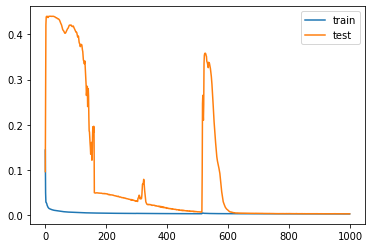

In [30]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [31]:
def get_image_test():
    path_test_photo = "D:\exia\A5 2021-2022\Option_DataScience\Dataset"
    test_image = [os.path.join(path_test_photo, x) for x in os.listdir(path_test_photo)][randrange(150)]
    return test_image

def do_test(photo_test, model):
    img = image.load_img(photo_test)
    img = preprocess(img)
    img_noise = noise_it(img)
    img_denoise_encoder = ae.predict(img_noise)
    print(img_denoise_encoder)
    display_image(img, 1)
    display_image(img_noise, 1)
    display_image(img_denoise_encoder, 1)
# test_image = get_image_test()
# do_test(test_image, history)

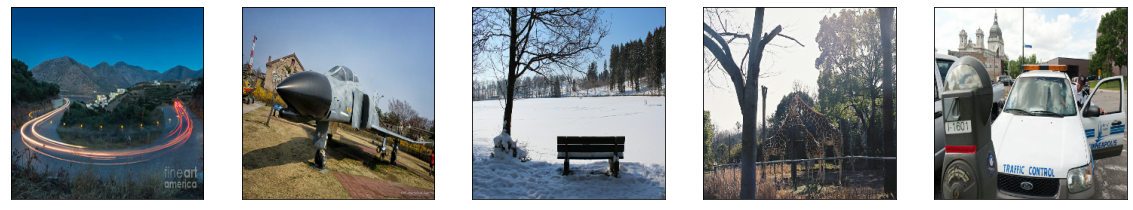

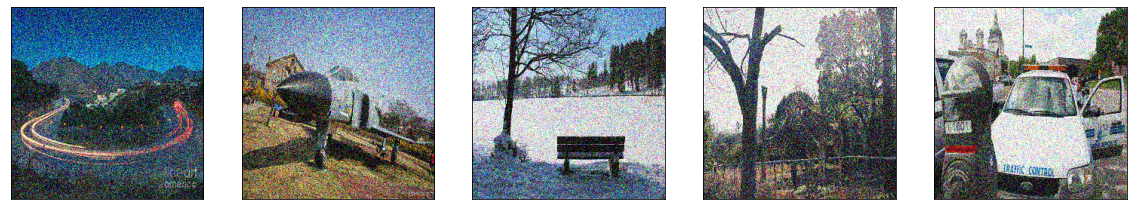

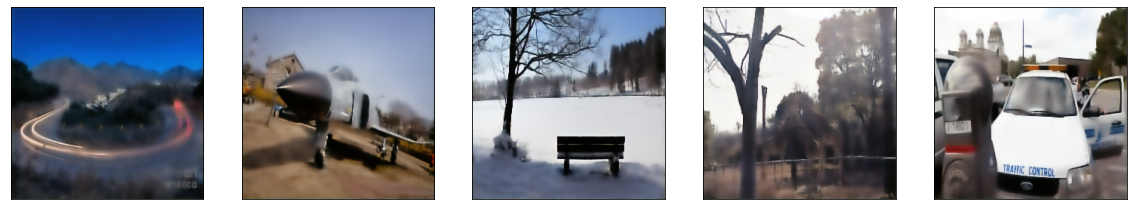

In [33]:
# input_img = Input(shape = (image_h, image_h,3))
# x = Conv2D(16, (3,3), activation = "relu", padding="same")(input_img)
# x = MaxPooling2D(pool_size=(2,2), padding="same")(x)
# x = Conv2D(32, (3,3), activation = "relu", padding="same")(x)
# encoded = MaxPooling2D()(x)
# x = Conv2D(32, (3,3), activation = "relu", padding="same")(encoded)
# x = UpSampling2D((2))(x)
# x = Conv2D(32, (3,3), activation = "relu", padding="same")(x)
# x = UpSampling2D()(x)
# decoded = Conv2D(3, (3, 3), activation= "sigmoid", padding="same")(x)

In [34]:
# inputs    = tf.keras.Input(shape=(28, 28, 3))

# latents   = encoder(inputs)
# outputs   = decoder(latents)

# ae = tf.keras.Model(inputs,outputs, name="ae")

# ae.compile(optimizer = tf.keras.optimizers.Adadelta(), loss = 'mse')
# ae.summary()

In [35]:
# autoencoder = tf.keras.Model(input_img, decoded)
# autoencoder.compile(optimizer="adadelta",
#                     loss= "binary_crossentropy")
# autoencoder.summary()

In [36]:
# history = ae.fit(x_train_noisy, x_train,
#                 epochs=nb_epochs,
#                 batch_size= batch_size,
#                 shuffle= False,
#                 validation_data=(x_test_noisy, x_test)
#                          )


In [37]:
# def create_dir():
#     bruit_dir = "D:\exia\A5 2021-2022\Option_DataScience\Bruit"
#     if not os.path.exists(bruit_dir):
#         print('test')
#         os.mkdir(bruit_dir)
#         dir_create = map(lambda x : os.path.join(bruit_dir,x), ['Bruit', 'Clean'])
#         [os.mkdir(x) for x in dir_create]
#     return list(map(lambda x: bruit_dir + '\\'+ x ,os.listdir(bruit_dir)))

# def noise_it(list_dir, path_dataset):
#     all_files = [os.path.join(path_dataset, x) for x in os.listdir(path_dataset)]
#     for index, photo in enumerate(all_files):
#         img = image.load_img(photo, target_size=(28, 28))
#         array_img = image.img_to_array(img)
# #         array_img = random_noise(array_img, mode='gaussian', mean=0, var=0.3)
# #         array_img = random_noise(array_img, mode='s&p',      amount=0.2, salt_vs_pepper=0.5)
# #         array_img = random_noise(array_img, mode='poisson') 
# #         array_img = random_noise(array_img, mode='speckle',  mean=0, var=0.1)
# #         array_img = Image.fromarray(array_img.astype('uint8'), 'RGB')
#         img.save(str(list_dir[1]) + "\\"+ photo.split('\\')[-1])
#         array_img.save(str(list_dir[0]) + "\\noisy_"+ photo.split('\\')[-1])
# list_dir = create_dir()
# noise_it(list_dir, r"D:\exia\A5 2021-2022\Option_DataScience\Datasets\Photo")